In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import aifc
import os
import tensorflow as tf
import random
import pandas as pd
from load_and_generate import *

In [4]:
def get_file_sequence(file_name, header):
    """Function to extract the information from the file name.
    
    Args:
    file_name: name of the file, containing the extension
    header: header to be removed from file
    
    Returns:
    Returns the sequence of a file. i.e: "0001" for file_name= "train0001.aiff", header= "train"
    """
    return file_name.split('.')[0].split(header)[1]

In [5]:
# RAW dimensions of image
image_height = 129
image_width = 23

# Selected dimensions appropiate for processing with ConvNets 

image_height = 32
image_width = 32

# Use maybe_extract function from load_and_generate module to 
# obtain the folders where dataset for each label is located 

train_folders = maybe_extract(os.path.abspath( '../whale-inputs/data/train/'))


['/home/mabelvj/Git/whale-inputs/data/train/no_whales', '/home/mabelvj/Git/whale-inputs/data/train/whales']


In [6]:
#Pickle file name 
pickle_file = 'exploration.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (8432, 32, 32), (8432,))
('Validation set', (2811, 32, 32), (2811,))
('Test set', (2811, 32, 32), (2811,))


In [9]:
# Each element of the array contains an image
train_dataset[0]

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ..., 
       [ 170.,  255.,   34., ...,    0.,    0.,   85.],
       [   0.,    0.,   23., ...,  127.,  127.,    0.],
       [   0.,    0.,   23., ...,    0.,  255.,  170.]], dtype=float32)

## Viewing some samples

In [11]:
#Separated from next cell to always have the same indexes and compare
N_plot = 9
sample_index = random.sample(range(len(train_dataset)),N_plot)

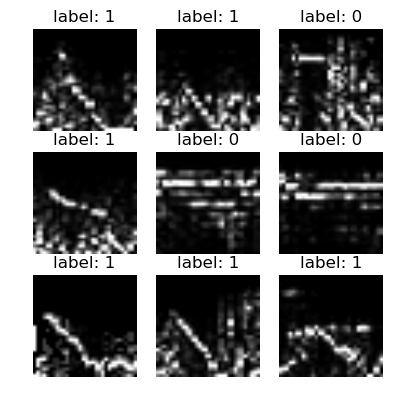

In [18]:
from sklearn import preprocessing

plt.figure(figsize=(4.5,4.5))
for i, index_image in enumerate(sample_index):

    plt.subplot(N_plot/2.5, 3, i+1)
    #Option 1: Unproccessed
    #Pxx_ = train_dataset[index_image]
    # Option 2 : Rescaled to 0-1
    #Pxx_ = preprocessing.MinMaxScaler().fit_transform(train_dataset[index_image]) #rescale to 0-1
    
    # Option 2.b: Rescaled to [0-1] and put in format [0-255]: Is the sames as option 1 but with smaller numbers: 
    # We keep this
    Pxx_prep = preprocessing.MinMaxScaler().fit_transform(train_dataset[index_image]) #rescale to 0-1
    Pxx_ = (Pxx_prep*255.0).astype(int)

    # Option 3 : applied np.log10
    #Pxx_prep = preprocessing.MinMaxScaler().fit_transform(np.log10(train_dataset[index_image])) #rescale to 0-1
    #Pxx_ = (Pxx_prep*255.0).astype(int)
    
    # Option 4 : 
    #Pxx_ = np.log10(train_dataset[index_image])
    #Pxx_ = preprocessing.MinMaxScaler().fit_transform(Pxx_prep) #rescale to 0-1
  
    # Option 5: Inverted 
    #Rescaled to [0-1] and put in format [0-255]: Is the sames as option 1 but with smaller numbers: 
    # We keep this
    #Pxx_ = 255.-train_dataset[index_image]
    
    imgplot = plt.imshow(Pxx_, cmap = 'gray')
    plt.title("label: %d"%train_labels[index_image])
    plt.axis('off')

## Logistic regression

Reused some code from the exercises of the course of Deep Learning to do the models in Tensorflow

In [28]:
batch_size = 50
hidden_nodes=1024
graph = tf.Graph()
num_labels = 2

beta_array = [0.002]

for beta in beta_array:
    with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_height * image_width))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

        # Variables.
      weights1 = tf.Variable(
                tf.truncated_normal([image_height * image_width, hidden_nodes]))
      biases1 = tf.Variable(tf.zeros([ hidden_nodes]))
      weights2 = tf.Variable(tf.truncated_normal([hidden_nodes,num_labels]))
      biases2 = tf.Variable(tf.zeros([num_labels]))


      def forward_prop(inp):
            h1 = tf.nn.relu(tf.matmul(inp, weights1)+biases1)
            
            return tf.matmul(h1,weights2) + biases2

      # Training computation.
      keep_prob = 0.5
      logits =  tf.nn.dropout(forward_prop(tf_train_dataset), keep_prob)

      print("beta: %.3f...\n"%beta)
    
      R = tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2)+tf.nn.l2_loss(biases1)+tf.nn.l2_loss(biases2)
 
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)+ beta*R)

      # Optimizer.
      global_step = tf.Variable(0)  # count the number of steps taken.
      learning_rate = tf.train.exponential_decay(0.1, global_step, 100000, 0.75, staircase=True)
      # tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name=None)
      optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
      test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

    num_steps = 8001

    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
      print("\n \n")

beta: 0.002...



ValueError: Shape (2811, 32, 32) must have rank 2

In [41]:
file_names[np.random.randint(0, len(file_names), N_plot)]

TypeError: only integer arrays with one element can be converted to an index

# Ground-truth

In [7]:
data_loc = '../whale-inputs/data' 
train_folder = 'train'
file_path = os.path.join(data_loc,train_folder) #change to test if desired

ground_truth = pd.read_csv(data_loc + '/train.csv', index_col= 0)
ground_truth.index.name

'clip_name'

In [8]:
ground_truth.label.unique()

array([0, 1])

In [9]:
ground_truth.head(10)

,label
clip_name,
train1.aiff,0
train2.aiff,0
train3.aiff,0
train4.aiff,0
train5.aiff,0
train6.aiff,1
train7.aiff,1
train8.aiff,0
train9.aiff,1


In [10]:
df = pd.concat([ground_truth, pd.get_dummies(ground_truth.label)], axis=1); 
print(df.head(10))

whales = df[df[1]==1].index.values
no_whales = df[df[0]==1].index.values

              label    0    1
clip_name                    
train1.aiff       0  1.0  0.0
train2.aiff       0  1.0  0.0
train3.aiff       0  1.0  0.0
train4.aiff       0  1.0  0.0
train5.aiff       0  1.0  0.0
train6.aiff       1  0.0  1.0
train7.aiff       1  0.0  1.0
train8.aiff       0  1.0  0.0
train9.aiff       1  0.0  1.0
train10.aiff      0  1.0  0.0


In [28]:
def convert_to_wav(file_name):
    import ffmpy
    ff = ffmpy.FFmpeg(inputs={file_name[:-5]+'.aiff': None}, outputs={file_name[:-5]+'.wav': ['-ar','8000']})
    ff.run()
    return file_name[:-5]+'.wav'
def remove_wav(file_name):
    os.remove(file_name)

Blue whales sounding... 

Blue whale 0 


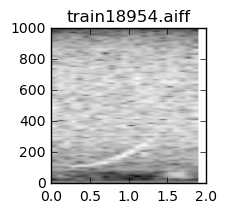

Blue whale 1 


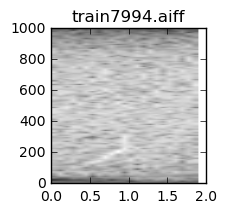

Blue whale 2 


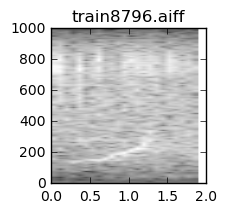

Blue whale 3 


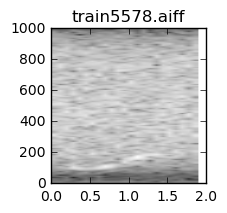

Blue whale 4 


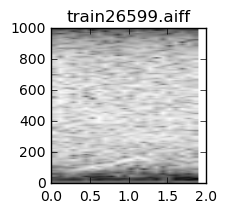

Blue whale 5 


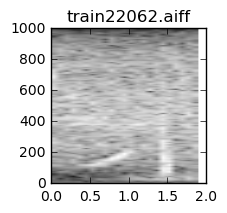

Blue whale 6 


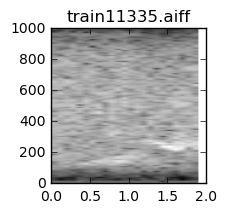

Blue whale 7 


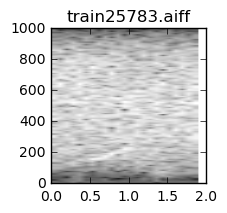

Blue whale 8 


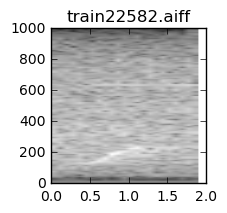

Blue whale 9 


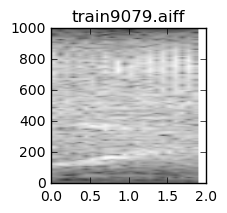

Blue whale 10 


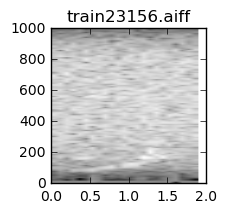

Blue whale 11 


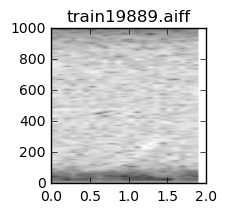

Blue whale 12 


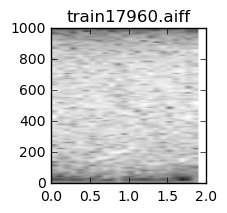

Blue whale 13 


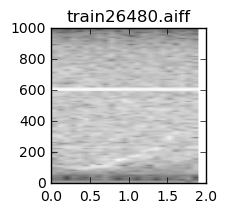

Blue whale 14 


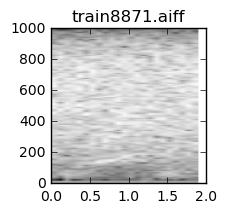



No blue whales sounding... 

Sound 0 


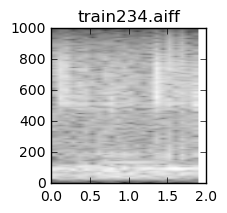

Sound 1 


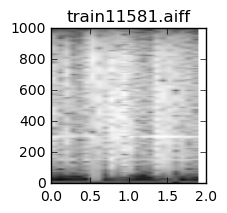

Sound 2 


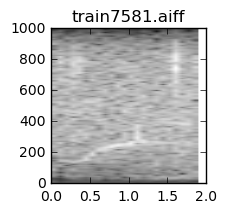

Sound 3 


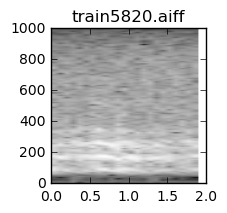

Sound 4 


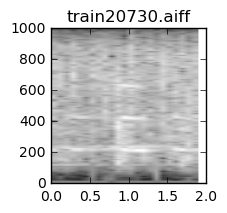

Sound 5 


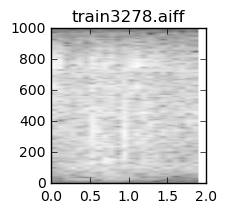

Sound 6 


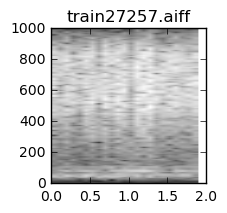

KeyboardInterrupt: 

In [40]:
import soundfile as sf
import sounddevice as sd
N_play= 15

print ("Blue whales sounding... \n")
for i, file_name in enumerate(random.sample(whales, N_play)):

    print ("Blue whale %d " %(i))
    
    f = aifc.open(file_path + '/whales/' +file_name, 'r')
    str_frames = f.readframes(f.getnframes())
    Fs = 2000
    time_data = np.fromstring(str_frames, np.short).byteswap()
    f.close()
 
    # spectrogram of file
    plt.figure(figsize=(2,2))
    Pxx, freqs, bins, im = plt.specgram(time_data,Fs=Fs,noverlap=90,cmap='gray')
    plt.title(file_name )
    plt.show()
    data, fs = sf.read(file_path + '/whales/' +file_name)
    sd.play(data, fs, blocking=True)

print('\n')
print ("No blue whales sounding... \n")    
for i, file_name in enumerate(random.sample(no_whales, N_play)):
    print ("Sound %d " %(i))
    f = aifc.open(file_path + '/no_whales/' +file_name, 'r')
    str_frames = f.readframes(f.getnframes())
    Fs = 2000
    time_data = np.fromstring(str_frames, np.short).byteswap()
    f.close()
 
    # spectrogram of file
    plt.figure(figsize=(2,2))
    Pxx, freqs, bins, im = plt.specgram(time_data,Fs=Fs,noverlap=90,cmap='gray')
    noise_power = 0.001 * Fs / 2
    plt.title(file_name )
    plt.show()
    data, fs = sf.read(file_path + '/no_whales/' +file_name)
    sd.play(data, fs, blocking=True)
    


In [37]:
import IPython.display
from IPython.display import Audio
import wave
import shutil

#whale

file_name =  os.path.join(train_folders[1],random.sample(whales, 1)[0])

print (file_name)

import os,sys
folder = file_name
#file_name_final =  file_name[:-3]+'.wav'
file_name_final = convert_to_wav(file_name)
print file_name_final

#f = wave.open(file_name_final, 'r')
#str_frames = f.readframes(f.getnframes())
#fs = f.getframerate()
#time_data = np.fromstring(str_frames, np.short).byteswap()

#f.close()

#print (time_data)
#Audio(data = time_data, rate = fs)
IPython.display.Audio(file_name_final)#, autoplay= True)

/home/mabelvj/Git/whale-inputs/data/train/whales/train4276.aiff
/home/mabelvj/Git/whale-inputs/data/train/whales/train4276.wav


In [19]:
os.remove(file_name_final)

OSError: [Errno 2] No such file or directory: '/home/mabelvj/Git/whale-inputs/data/train/whales/train19422.wav'

In [20]:
# Generate a sound
import IPython
import numpy as np
framerate = 44100
t = np.linspace(0,5,framerate*5)
tone = np.sin(2*np.pi*220*t)
antitone = np.sin(2*np.pi*220*t + np.pi)
IPython.display.Audio(tone+antitone, rate=framerate)

In [25]:
%matplotlib inline
plt.figure(figsize=(25.,18.))
N_plot = 12
print ("Blue whales sounding... \n")
for i, file_name in enumerate(random.sample(whales,N_plot)):
    f = aifc.open(os.path.join(file_path,file_name), 'r')
    str_frames = f.readframes(f.getnframes())
    #Fs = f.getframerate()
    Fs = 2000
    time_data = np.fromstring(str_frames, np.short).byteswap()
    f.close()
 
    # spectrogram of file
    plt.subplot(N_plot/4, 4, i+1)
    Pxx, freqs, bins, im = plt.specgram(time_data,Fs=Fs,noverlap=90,cmap='gray')
    noise_power = 0.001 * Fs / 2
    plt.title(train_folder +' ' + get_file_sequence(file_name, train_folder) )

plt.show()


plt.figure(figsize=(25.,18.))
N_plot = 12
print('\n')
print ("No blue whales sounding... \n")  
for i, file_name in enumerate(random.sample(whales,N_plot)):
    f = aifc.open(os.path.join(file_path,file_name), 'r')
    str_frames = f.readframes(f.getnframes())
    #Fs = f.getframerate()
    Fs = 2000
    time_data = np.fromstring(str_frames, np.short).byteswap()
    f.close()
 
    # spectrogram of file
    plt.subplot(N_plot/4, 4, i+1)
    Pxx, freqs, bins, im = plt.specgram(time_data,Fs=Fs,noverlap=90,cmap='gray')
    noise_power = 0.001 * Fs / 2
    plt.title(train_folder +' ' + get_file_sequence(file_name, train_folder) )
plt.show() 

Blue whales sounding... 



IOError: [Errno 2] No such file or directory: '../whale-inputs/data/train/train22240.aiff'